In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
! pip install wandb -U -qqq
! pip install sklearn -U -qqq
! pip install xgboost -U -qqq # ==1.6.0 #
! pip install catboost -U -qqq
! pip install optuna -U -qqq
! pip install flaml -U -qqq

In [27]:

import os
import random
import sys
import shutil
import gc
import pickle
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import joblib
from functools import partial
from timeit import default_timer as timer

sns.set_style('darkgrid')
from sklearn.datasets import fetch_california_housing

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, SGDOneClassSVM
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# from sklearn.neighbors import LocalOutlierFactor

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------------

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LassoCV
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool
import xgboost as xgb
import lightgbm as lgb

from flaml import AutoML
from flaml.automl.model import LGBMEstimator, XGBoostEstimator, CatBoostEstimator, \
        RandomForestEstimator, ExtraTreesEstimator, KNeighborsEstimator

# LRL1Classifier: The class for tuning Logistic Regression with L1 regularization.

# ---------------

import torch
import optuna

from scipy.stats.mstats import winsorize
from scipy.stats import mode

import wandb

# import category_encoders as ce



In [28]:

def set_seeds(config):
  np.random.seed(config["random_state"])
  random.seed(config["random_state"])
  os.environ["PYTHONHASHSEED"] = str(config["random_state"])
  '''
  torch.manual_seed(config["random_state"])
  if torch.cuda.is_available():
      torch.cuda.manual_seed(config["random_state"])
      torch.cuda.manual_seed_all(config["random_state"])
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = True
  '''


def generate_fold_idx(config, train_df, group_col=None):
  if config['fold_split_type'] == 'kfold':
    splitter = KFold(n_splits=config['num_folds'], shuffle=True,
                                     random_state=config['random_state'])
  elif config['fold_split_type'] == 'strat_kfold':
    splitter = StratifiedKFold(n_splits=config['num_folds'], shuffle=True,
                                     random_state=config['random_state'])
  elif config['fold_split_type'] == 'group_kfold':
    splitter = GroupKFold(n_splits=config['num_folds'])
  elif config['fold_split_type'] == 'time_series_split':  # can use purged as well.
    splitter = TimeSeriesSplit(n_splits=config['num_folds'])
  else:
    raise ValueError("fold_split_type {} not recognized... Choose from: \
                    time_series_split, group_time_series_split, purged_time_series_split, kfold")

  fold_idx_dict = dict()
  if config['fold_split_type'] == 'group_kfold':
    if group_col in train_df.columns:
      for fold_idx, (train_idx, val_idx) in enumerate(splitter.split(X=train_df,
                                                                    groups=train_df[group_col].values)):
        fold_idx_dict[fold_idx] = dict()
        fold_idx_dict[fold_idx]['train_idx'] = train_idx
        fold_idx_dict[fold_idx]['val_idx'] = val_idx
  else:
    print(">>>>> train_df.columns: ", train_df.columns)
    for fold_idx, (train_idx, val_idx) in enumerate(splitter.split(X=train_df, y=train_df[config['target_cols'][0]].values)):
      fold_idx_dict[fold_idx] = dict()
      fold_idx_dict[fold_idx]['train_idx'] = train_idx
      fold_idx_dict[fold_idx]['val_idx'] = val_idx

  return fold_idx_dict


def save_automl_model(config, model):
  model_save_fname = config['curr_model_name'] + '.pkl'
  model_local_save_path = os.path.join(config['local_model_dir'], model_save_fname)
  model_drive_save_path = os.path.join(config['drive_model_dir'], model_save_fname)

  with open(model_local_save_path, 'wb') as fp:
    pickle.dump(model, fp, pickle.HIGHEST_PROTOCOL)

  print('Copying model to drive...')
  shutil.copy(model_local_save_path, model_drive_save_path)


def load_automl_model(config):
  model_save_fname = config['curr_model_name'] + '.pkl'
  model_local_save_path = os.path.join(config['local_model_dir'], model_save_fname)
  model_drive_save_path = os.path.join(config['drive_model_dir'], model_save_fname)

  print('Copying model from drive...')
  shutil.copy(model_drive_save_path, model_local_save_path)

  with open(model_local_save_path, 'rb') as fp:
    model = pickle.load(fp)

  return model


def save_seeds(config, k_seeds):
  seed_fname = 'k_seeds_fold_'+str(config['curr_fold'])+'.pkl'
  seeds_local_save_path = os.path.join(config['local_model_dir'], seed_fname)
  seeds_drive_save_path = os.path.join(config['drive_model_dir'], seed_fname)

  with open(seeds_local_save_path, 'wb') as fp:
    pickle.dump(k_seeds, fp, pickle.HIGHEST_PROTOCOL)

  print('Copying seeds to drive...')
  shutil.copy(seeds_local_save_path, seeds_drive_save_path)


def load_seeds(config):
  seed_fname = 'k_seeds_fold_'+str(config['curr_fold'])+'.pkl'
  seeds_local_save_path = os.path.join(config['local_model_dir'], seed_fname)
  seeds_drive_save_path = os.path.join(config['drive_model_dir'], seed_fname)

  print('Copying seeds from drive...')
  shutil.copy(seeds_drive_save_path, seeds_local_save_path)

  with open(seeds_local_save_path, 'rb') as fp:
    k_seeds = pickle.load(fp)
  return k_seeds


def save_model(config, ensemble_ref):
  model_save_names_dict = dict()
  for model_id in ensemble_ref.model_ids:
    model_save_names_dict[model_id] = model_id + '_fold_' + str(config['curr_fold'])

  for model_id, model_config in ensemble_ref.all_models_dict.items():
    if 'sklearn' in model_config['model_family']:
      fname_extension = '.pkl'
    elif model_config['model_family'] == 'xgb':
      if 'enable_categorical' in model_config['model_params'].keys() and \
        model_config['model_params']['enable_categorical']: fname_extension += '.json'
      else: fname_extension += '.xgb'
    elif model_config['model_family'] == 'lgb': fname_extension = '.pkl'
    elif model_config['model_family'] == 'cb': fname_extension = ''
    elif model_config['model_family'] == 'tabnet': raise NotImplemented
    else:
      raise ValueError(f"parameter `model_family` with value: {model_config['model_family']}. Not understood.")

    model_save_fname = model_save_names_dict[model_id] + fname_extension
    model_local_save_path = os.path.join(config['local_model_dir'], model_save_fname)
    model_drive_save_path = os.path.join(config['drive_model_dir'], model_save_fname)

    if 'sklearn' in model_config['model_family']:
      with open(model_local_save_path, 'wb') as fp:
        pickle.dump(model_config['model_ref'], fp)
    elif model_config['model_family'] == 'lgb':
      joblib.dump(model_config['model_ref'], model_local_save_path)
    else:
      model_config['model_ref'].save_model(model_local_save_path)

    shutil.copy(model_local_save_path, model_drive_save_path)


def load_model(config, ensemble_ref):
  model_save_names_dict = dict()
  for model_id in ensemble_ref.model_ids:
    model_save_names_dict[model_id] = model_id + '_fold_' + str(config['curr_fold'])

  for model_id, model_config in ensemble_ref.all_models_dict.items():
    if 'sklearn' in model_config['model_family']:
      fname_extension = '.pkl'
    elif model_config['model_family'] == 'xgb':
      if 'enable_categorical' in model_config['model_params'].keys() and \
        model_config['model_params']['enable_categorical']: fname_extension += '.json'
      else: fname_extension += '.xgb'
    elif model_config['model_family'] == 'lgb': fname_extension = '.pkl'
    elif model_config['model_family'] == 'cb': fname_extension = ''
    elif model_config['model_family'] == 'tabnet': raise NotImplemented
    else:
      raise ValueError("parameter `model_family` with value: ", model_config['model_family'])

    model_save_fname = model_save_names_dict[model_id] + fname_extension
    model_local_save_path = os.path.join(config['local_model_dir'], model_save_fname)
    model_drive_save_path = os.path.join(config['drive_model_dir'], model_save_fname)
    shutil.copy(model_drive_save_path, model_local_save_path)
    if 'sklearn' in model_config['model_family']:
      with open(model_local_save_path, 'rb') as fp:
        model = pickle.load(fp)
    elif model_config['model_family'] == 'xgb':
      model = xgb.XGBRegressor()
      model.load_model(model_local_save_path)
    elif model_config['model_family'] == 'lgb':
      model = joblib.load(model_local_save_path)
    elif model_config['model_family'] == 'cb':
      model = CatBoostRegressor()
      model.load_model(model_local_save_path)
    elif model_config['model_family'] == 'tabnet':
      raise NotImplemented
    else:
      raise ValueError(f"parameter `model_family` with value: {model_config['model_family']}. Not understood.")

    model_config['model_ref'] = model

  return ensemble_ref


def save_config(config, save_fname='config'):
  config_to_save = {}  # to avoid types like object or others that somtimes cause problem reading the data back.
  for k, v in config.items():
    if isinstance(v, (bool, int, float, str, list, dict, tuple, set)) or v is None:
      config_to_save[k] = v

  config_local_save_path = os.path.join(config['local_model_dir'], f'{save_fname}.json')
  config_drive_save_path = os.path.join(config['drive_model_dir'], f'{save_fname}.json')

  with open(config_local_save_path, 'w') as fp:
    json.dump(config_to_save, fp, indent=4, sort_keys=True)

  shutil.copy(config_local_save_path, config_drive_save_path)


def load_config(config, load_fname='config'):
  config_local_save_path = os.path.join(config['local_model_dir'], f'{load_fname}.json')
  config_drive_save_path = os.path.join(config['drive_model_dir'], f'{load_fname}.json')

  shutil.copy(config_drive_save_path, config_local_save_path)

  with open(config_local_save_path, 'r') as fp:
    model_config = json.load(fp)

  return model_config


def save_ensemble_config(config, ensemble_ref):
  all_models_dict_cpy = copy.deepcopy(ensemble_ref.all_models_dict)

  for model_id, model_config in all_models_dict_cpy.items():
    _ = model_config.pop('model_ref', '`model_ref` Key not found while deleting.')

    if ('model_params' in model_config.keys()) and (model_config['model_params'] is not None):
      model_params_clean = {}
      for k, v in model_config['model_params'].items():
        if isinstance(v, (bool, int, float, str, list, dict, tuple, set)) or v is None:
          model_params_clean[k] = v
      model_config['model_params'] = model_params_clean

  config_local_save_path = os.path.join(config['local_model_dir'], 'all_models_dict.json')
  config_drive_save_path = os.path.join(config['drive_model_dir'], 'all_models_dict.json')

  with open(config_local_save_path, 'w') as fp:
    json.dump(all_models_dict_cpy, fp, indent=4, sort_keys=True)

  shutil.copy(config_local_save_path, config_drive_save_path)


def load_ensemble_config(config):
  config_local_save_path = os.path.join(config['local_model_dir'], 'all_models_dict.json')
  config_drive_save_path = os.path.join(config['drive_model_dir'], 'all_models_dict.json')

  shutil.copy(config_drive_save_path, config_local_save_path)

  with open(config_local_save_path, 'r') as fp:
    model_config = json.load(fp)

  return model_config



def get_model_params(config):
  model_params = {
            'random_state': config['random_state'],
            'n_jobs': config['n_jobs'],
            'verbose': config['verbose'],

            'boosting_type': config['boosting_type'],
            'max_depth': config['max_depth'],
            # 'max_leaves': config['max_leaves'],
            'num_leaves': config['num_leaves'],
            'n_estimators': config['n_estimators'],
            'early_stopping_round': config['early_stopping_round'],

            'colsample_bytree': config['colsample_bytree'],
            'subsample': config['subsample'],

            # 'enable_categorical': config['enable_categorical'],

            'reg_alpha': config['reg_alpha'],
            'reg_lambda': config['reg_lambda'],
            'drop_rate': config['drop_rate'],
            'max_drop': config['max_drop'],

            'max_bin': config['max_bin'],
            'min_data_in_leaf': config['min_data_in_leaf'],
            'min_child_weight': config['min_child_weight'],
            'force_col_wise': config['force_col_wise'],

            'learning_rate': config['learning_rate'],
            'objective': config['objective'],

            'metric': config['eval_metric'],
            # 'eval_metric': cohen,
        }

  model_params['max_leaves'] = model_params['num_leaves']
  model_params['early_stopping_rounds'] = model_params['early_stopping_round']
  model_params['min_child_samples'] =  model_params['min_data_in_leaf']

  return model_params



In [29]:

def get_data(config):
  for fname in ['train.csv', 'test.csv', 'sample_submission.csv']:
    shutil.copy(os.path.join(config['drive_data_dir'], fname),
                os.path.join(config['local_data_dir'], fname)
                )
  train_df = pd.read_csv(os.path.join(config['local_data_dir'], 'train.csv'))
  test_df = pd.read_csv(os.path.join(config['local_data_dir'], 'test.csv'))
  sub_df = pd.read_csv(os.path.join(config['local_data_dir'], 'sample_submission.csv'))
  print("Read shape: train_df.shape: ", train_df.shape)
  print("Read columns: train_df.columns: ", train_df.columns)
  print("Read shape: test_df.shape: ", test_df.shape)
  print("Read shape: sub_df.shape: ", sub_df.shape)

  train_df['original_data'] = False
  train_df.set_index('id', inplace=True, drop=True)

  # -------------------------------

  for fname in ['orig_data.csv']:
    shutil.copy(os.path.join(config['drive_data_dir'], fname),
                os.path.join(config['local_data_dir'], fname)
                )
  orig_data_df = pd.read_csv(os.path.join(config['local_data_dir'], 'orig_data.csv'))
  print("Read shape: orig_data_df.shape: ", orig_data_df.shape)

  unnamed_cols = []
  for col in orig_data_df.columns:
    if col.startswith('Unnamed'): unnamed_cols.append(col)
  orig_data_df.drop(unnamed_cols, axis=1, inplace=True)

  orig_data_df['id'] = np.arange(orig_data_df.shape[0])
  orig_data_df.set_index('id', drop=True, inplace=True)

  start = train_df.index.values.max() + 1
  new_idx = np.arange(start, start+orig_data_df.shape[0])
  orig_data_df.index = new_idx

  orig_data_df['original_data'] = True

  return train_df, test_df, sub_df, orig_data_df


def encode_features(config, train_df, test_df):
  if config['predict_log']:
    train_df['Strength_log'] = np.log(train_df['Strength'].values)

  return train_df, test_df


def update_feature_dtypes(config, train_df, test_df):
  for col in config['bool_cols']:
      train_df[col] = train_df[col].astype('category')
      test_df[col] = test_df[col].astype('category')

  return train_df, test_df


def get_feature_cols(config, train_df):
  config['id_cols'] = ['id', 'original_data']

  if config['predict_log']:
    config['target_cols'] = ['yield_log']
  else:
    config['target_cols'] = ['yield']

  config['bool_cols'] = []

  non_feature_cols = config['id_cols'] + config['target_cols']

  config['feature_cols'] = []
  for col in train_df.columns:
    if col not in non_feature_cols:
      config['feature_cols'].append(col)

  return config


def scale_data_fn(config, train_df, test_df):

  cols_to_scale = config['feature_cols'] # MAKE SURE THESE ARE ALL CONT. FEATURES.

  if config['scaler_type'] == 'standard':
    scaler = StandardScaler()
  elif config['scaler_type'] == 'robust':
    scaler = RobustScaler()
  elif config['scaler_type'] == 'minmax':
    scaler = MinMaxScaler()

  scaler.fit(train_df[cols_to_scale].values)
  train_df[cols_to_scale] = scaler.transform(train_df[cols_to_scale])
  test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

  return train_df, test_df


In [30]:

def IQR_outlier_handling(train_df, test_df, cols, handling_type):
  for col in cols:
    # calculate interquartile range
    q25, q75 = np.percentile(train_df[col].values, 25), np.percentile(train_df[col].values, 75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower_cutoff, upper_cutoff = q25 - cut_off, q75 + cut_off

    num_outliers = train_df[col].loc[(train_df[col] < lower_cutoff) | (train_df[col] > upper_cutoff)].shape[0]
    print("col: {} \t # num_outliers: {}".format(col, num_outliers))

    if handling_type == 'remove_train_clip_test':
      train_df[col] = train_df[col].loc[(not(train_df[col] < lower_cutoff)) & (not(train_df[col] > upper_cutoff))]
      if col in test_df.columns:
        test_df[col].loc[test_df[col] < lower_cutoff] = lower_cutoff
        test_df[col].loc[test_df[col] > upper_cutoff] = upper_cutoff
    elif handling_type == 'clip':
      train_df[col].loc[train_df[col] < lower_cutoff] = lower_cutoff
      train_df[col].loc[train_df[col] > upper_cutoff] = upper_cutoff
      if col in test_df.columns:
        test_df[col].loc[test_df[col] < lower_cutoff] = lower_cutoff
        test_df[col].loc[test_df[col] > upper_cutoff] = upper_cutoff

    return train_df, test_df



def winsorize_outlier_handling(train_df, test_df, cols, lower_lim=0.01, upper_lim=0.98):
  # lower_lim = train_df.quantile(0.01)
  # upper_lim = train_df.quantile(0.99)
  for col in cols:
    train_df[col] = winsorize(train_df[col], (lower_lim, upper_lim))
    test_df[col] = winsorize(test_df[col], (lower_lim, upper_lim))

  return train_df, test_df



def isolation_forest_outlier_handling(train_df, test_df, cols, outlier_thresh=-0.1,
                                      handling_method='drop_median', seed=0):
  print("Training Isolation forest model to detect outliers...")
  iso_forest_model = IsolationForest(n_estimators=500, contamination='auto', random_state=seed)
  iso_forest_model.fit(train_df[cols], train_df.MedHouseVal.values)

  sample_scores_train = iso_forest_model.decision_function(train_df[cols])
  sample_scores_test = iso_forest_model.decision_function(test_df[cols])

  print("# train outliers: ", np.sum(sample_scores_train < outlier_thresh))
  print("# test outliers: ", np.sum(sample_scores_test < outlier_thresh))

  if handling_method == 'drop_median':
    print("Dropping outlier train samples...")
    # drop train samples and replace test sample values with median from train columns
    train_df = train_df.loc[sample_scores_train >= outlier_thresh]

    print("Clipping outlier test samples to median value...")
    for col in cols:
      test_df[col].loc[sample_scores_test < outlier_thresh] = train_df[col].median(axis=0)
  elif handling_method == 'winsorize':
    train_df.loc[sample_scores_train < outlier_thresh] = winsorize_outlier_handling(train_df.loc[sample_scores_train < outlier_thresh],
                                                                  cols, lower_lim=0.01, upper_lim=0.98)
    test_df.loc[sample_scores_test < outlier_thresh] = winsorize_outlier_handling(test_df.loc[sample_scores_test < outlier_thresh],
                                                                  cols, lower_lim=0.01, upper_lim=0.98)

  return train_df, test_df


def manual_outlier_handling(config, train_df, test_df):
  train_df[train_df.made==10000].made = 2000  # Not sure what other year to set here.

  return train_df, test_df


def handle_outliers(config, train_df, test_df, cols):
  if config['outlier_handling_method'] == 'manual':
    train_df, test_df = manual_outlier_handling(train_df, test_df, cols=cols)
  if config['outlier_handling_method'] == 'winsorize':
    train_df, test_df = winsorize_outlier_handling(train_df, test_df, cols=cols)
  elif config['outlier_handling_method'] == 'iso_forest':
    train_df, test_df = isolation_forest_outlier_handling(train_df, test_df, cols=cols,
                                  outlier_thresh=-0.1, handling_method='drop_median', seed=config['seed'])
  elif config['outlier_handling_method'] == 'iqr':
    train_df, test_df = IQR_outlier_handling(train_df, test_df, cols, handling_type='clip')

  return train_df, test_df


In [31]:


def get_config():
  return config


def across_col_feat_v1(config, df):
  df['all_bee_densities_sum'] = df['honeybee'] + df['bumbles'] + df['andrena'] + df['osmia']

  # ------------

  df['clonesize_sq'] = df['clonesize']**2
  df['clonesize_sqrt'] = df['clonesize']**0.5
  df['clonesize_log'] = np.log(df['clonesize'])
  df['clonesize_log'].fillna(0, inplace=True)
  df['clonesize_log'].replace([np.inf, -np.inf], 0, inplace=True)
  df['clonesize_by_max_clonesize'] = df['clonesize'] / df['clonesize'].max()
  df['clonesize_by_min_clonesize'] = df['clonesize'] / df['clonesize'].min()
  df['clonesize_minus_avg_clonesize'] = df['clonesize'] - df['clonesize'].mean()

  # ------------

  # assuming more bees is significantly higher indicator of pollination in that area; than linear
  df['honeybee_sq'] = df['honeybee']**2
  df['bumbles_sq'] = df['bumbles']**2
  df['andrena_sq'] = df['andrena']**2
  df['osmia_sq'] = df['osmia']**2

  # ------------

  # how much did it rain compared to avg levels
  df['rain_levels'] = df['RainingDays'] / df['AverageRainingDays'].replace(0, 1e-5)

  # dont know much about this set of features; so calculating generic features
  df["fruitset_into_seed"] = df["fruitset"] * df["seeds"]
  df["fruitmass_into_seeds"] = df["fruitmass"] * df["seeds"]
  df["fruitset_into_fruitmass"] = df["fruitset"] * df["fruitmass"]

  for fname1 in ['fruitset', 'fruitmass', 'seeds']:
    for fname2 in ['fruitset', 'fruitmass', 'seeds']:
      df[fname1 + '_by_' + fname2] = df[fname1] / df[fname2].replace(0, 1e-5)

  # binning continuous features into discrete labels
  for n_quantiles in [5, 10, 15]:
    df[f'fruitset_{n_quantiles}_quantile_ids'] = pd.qcut(df['fruitset'], n_quantiles, labels=np.arange(0, n_quantiles)).astype(int)
    df[f'fruitmass_{n_quantiles}_quantile_ids'] = pd.qcut(df['fruitmass'], n_quantiles, labels=np.arange(0, n_quantiles)).astype(int)
    df[f'seeds_{n_quantiles}_quantile_ids'] = pd.qcut(df['seeds'], n_quantiles, labels=np.arange(0, n_quantiles)).astype(int)

  # ------------

  df['LowerTRangeSpan'] = df['MaxOfLowerTRange'] - df['MinOfLowerTRange']
  df['LowerTRangeAbvAvg'] = df['MaxOfLowerTRange'] - df['AverageOfLowerTRange']
  df['LowerTRangeBelAvg'] = df['AverageOfLowerTRange'] - df['MinOfLowerTRange']

  df['UpperTRangeSpan'] = df['MaxOfUpperTRange'] - df['MinOfUpperTRange']
  df['UpperTRangeAbvAvg'] = df['MaxOfUpperTRange'] - df['AverageOfUpperTRange']
  df['UpperTRangeBelAvg'] = df['AverageOfUpperTRange'] - df['MinOfUpperTRange']


  LowerTRangeOneThirdAbvAvg = df['LowerTRangeAbvAvg']*0.33
  LowerTRangeOneThirdBelAvg = df['LowerTRangeBelAvg']*0.33
  UpperTRangeOneThirdAbvAvg = df['LowerTRangeAbvAvg']*0.33
  UpperTRangeOneThirdBelAvg = df['LowerTRangeBelAvg']*0.33

  df['OneThirdAbv_AverageOfLowerTRange'] = df['AverageOfLowerTRange'] + LowerTRangeOneThirdAbvAvg
  df['TwoThirdAbv_AverageOfLowerTRange'] = df['AverageOfLowerTRange'] + LowerTRangeOneThirdAbvAvg*2
  df['OneThirdBel_AverageOfLowerTRange'] = df['AverageOfLowerTRange'] - LowerTRangeOneThirdBelAvg
  df['TwoThirdBel_AverageOfLowerTRange'] = df['AverageOfLowerTRange'] - LowerTRangeOneThirdBelAvg*2

  df['OneThirdAbv_AverageOfUpperTRange'] = df['AverageOfUpperTRange'] + UpperTRangeOneThirdAbvAvg
  df['TwoThirdAbv_AverageOfUpperTRange'] = df['AverageOfUpperTRange'] + UpperTRangeOneThirdAbvAvg*2
  df['OneThirdBel_AverageOfUpperTRange'] = df['AverageOfUpperTRange'] - UpperTRangeOneThirdBelAvg
  df['TwoThirdBel_AverageOfUpperTRange'] = df['AverageOfUpperTRange'] - UpperTRangeOneThirdBelAvg*2

  # ------------

  df.fillna(0, inplace=True)
  df.replace([np.inf, -np.inf], 0, inplace=True)

  return df


def across_col_feat_v2(config, df):
  raise NotImplementedError
  return df


def across_col_feat_v3(config, df):
  raise NotImplementedError
  return df


def extract_features(config, train_df, test_df):
  '''
  Keep is min: original data set is imaginary.
  We can best aim for finding logic dataset author may have used to put in price values.
  '''
  if config['feature_version'] is None:
    pass
  elif config['feature_version'] == 'v1':
    train_df = across_col_feat_v1(config, train_df)
    test_df = across_col_feat_v1(config, test_df)
  elif config['feature_version'] == 'v2':
    raise NotImplementedError
  elif config['feature_version'] == 'v3':
    raise NotImplementedError
  else:
    print("Feature version {} not supported. Choose from : None, v1".format(config['feature_version']))
    raise

  return train_df, test_df


# consider prior distribution of labels?
def find_optimal_cuts():
  pass


def preprocess(config, train_df, test_df, fill_nans=False):

  # zero_fill_val = 1e-2
  # train_df['x'] = train_df['x'].replace(0, zero_fill_val)
  # train_df['y'] = train_df['z'].replace(0, zero_fill_val)
  # train_df['z'] = train_df['z'].replace(0, zero_fill_val)

  # train_df['depth'].fillna(train_df['depth'].median(), inplace=True)

  '''
  raise_exp = False
  for col in train_df.columns:
    if col in ['id']:
      continue
    nan_cnt = np.sum(np.isnan(train_df[col].values))
    inf_cnt = np.sum(np.isinf(train_df[col].values))
    if nan_cnt > 0:
      print("col: {} has {} nans...".format(col, nan_cnt))
      raise_exp = True
    if inf_cnt > 0:
      print("col: {} has {} infs...".format(col, inf_cnt))
      raise_exp = True


  if raise_exp:
    print("Nans/Infs detected...")
    raise
  '''

  return train_df, test_df


In [32]:

# https://github.com/microsoft/FLAML/blob/main/flaml/automl/model.py

class MyLGBM(LGBMEstimator):
  def __init__(self, **config):
      super().__init__(objective="regression_l1", #early_stopping_round=300,
                        metric= 'mean_absolute_error', **config)

class MyXGB(XGBoostEstimator):
  def __init__(self, **config):
      super().__init__(objective='reg:absoluteerror', #early_stopping_rounds=300,
                        eval_metric= 'mae', **config)

class MyCB(CatBoostEstimator):
  def __init__(self, **config):
      super().__init__(objective='MAE', #early_stopping_rounds=300,
                        eval_metric= 'MAE', **config)

class MyRF(RandomForestEstimator):
  def __init__(self, **config):
      super().__init__(criterion='absolute_error', **config)

class MyET(ExtraTreesEstimator):
  def __init__(self, **config):
      super().__init__(criterion='absolute_error', **config)

class MyKNN(KNeighborsEstimator):
  def __init__(self, **config):
      super().__init__(**config)



In [33]:

class AutoMLFitter:
  # A wrapper of the automl call to allow us to
  # decrease the time budget for each call
  # And keep track of the best parameters found

  def __init__(self, name, time_budget, estimator_list=[], best_config=None, n_folds=10):
    self.name = name
    self.time_budget = time_budget
    self.estimator_list = estimator_list
    self.best_config = best_config
    self.n_folds = n_folds

  def fit_automl(self, config, X, y, random_state=None):
    if random_state is None:
      if 'curr_seed' in config.keys():
        random_state = config['curr_seed']
    if random_state is None:
      raise ValueError("`random_state` is None. Pass seed value as parameter `random_state` or  \
                        have `curr_seed` key value in the config dictionary.")

    # https://microsoft.github.io/FLAML/docs/reference/automl/automl/
    # NOTE: Do not mode this to the constructor. This needs to update with new seed,
    # every time fit_automlis called with random state.
    self.automl_settings = {
        "time_budget": self.time_budget,
        "metric": 'mae',
        "task": 'regression',
        "ensemble": False,
        "eval_method": 'cv',
        "n_splits": self.n_folds,
        "seed": random_state,
        "verbose": 1, # Default: 3
        "estimator_list": self.estimator_list,
        "log_file_name": os.path.join(config['local_model_dir'], self.name+'_automl_log.txt')
    }

    # time budget is decreased on each call to fit_automl() from the same object.
    # Disabling for now.
    # self.time_budget //= 1.5
    # if self.time_budget < MIN_TIME_BUDGET:
    #     self.time_budget = MIN_TIME_BUDGET

    automl = AutoML()
    for estimator in config['estimator_list']:
      if estimator=='lgbm': est_name, learner_class = 'my_lgbm', MyLGBM
      elif estimator=='xgb': est_name, learner_class = 'my_xgb', MyXGB
      elif estimator=='cb': est_name, learner_class = 'my_cb', MyCB
      elif estimator=='et': est_name, learner_class = 'my_et', MyET
      elif estimator=='knn': est_name, learner_class = 'my_knn', MyKNN

      automl.add_learner(learner_name=est_name, learner_class=MyLGBM)
      self.automl_settings["estimator_list"].append(est_name)

    # self.fit_kwargs_by_estimator = {'my_lgbm': {'early_stopping_round': 50}}

    automl.fit(X, y, starting_points=self.best_config, # fit_kwargs_by_estimator=self.fit_kwargs_by_estimator,
               **self.automl_settings)
    self.best_config = automl.best_config_per_estimator

    return automl


In [34]:
def plot_score_from_dict(score_dict, title='Mean Absolute Error', ascending=True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending=ascending)
    print("score_df: ", score_df)
    plt.figure(figsize=(14, 8))
    sns.barplot(x='value', y='variable', data=score_df, palette='Blues_r', errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()

In [35]:

def mattop_post_process(config, preds, train_df):
  unique_targets = np.unique(train_df[config['target_cols']])
  return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])


def postprocess(config, preds, train_df=None):
  if config['postprocess_approach'] == 'nearest_neighbour':
    '''
    # For each predicted value, finds a nearest value from the training set and it will be used as our predictions.
      # processed_pred = []
      # for pred in test_predss:
      #   abs_diffs = []
      #   for target in unique_targets:
      #     abs_diffs.append(abs(pred-target))
      #   processed_pred.append(min(abs_diffs))
    '''
    unique_targets = np.unique(train_df[config['target_cols']])
    return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])
  else:
    print(f"Postprocessing approach {config['postprocess_approach']} not understood.")
    raise NotImplemented



In [36]:

def train_k_folds():

  # needed becuse variable that is updated within function becomes a local variable and has to be passed in.
  config = get_config()

  create_paths(config)
  train_df, test_df, sub_df, orig_data_df = get_data(config)
  print("train_df.shape: ", train_df.shape)
  print("test_df.shape: ", test_df.shape)
  print("sub_df.shape: ", sub_df.shape)
  print("orig_data_df.shape: ", orig_data_df.shape)

  for col in train_df.columns:
    if col not in orig_data_df.columns:
      print("!!! column {} is in train_df but not in orig_data_df...".format(col))

  for col in orig_data_df.columns:
    if col not in train_df.columns:
      print("!!! column {} is in orig_data_df but not in train_df...".format(col))

  # ---------------

  config = get_feature_cols(config, train_df)

  if config['include_orig_data']:
    if config['validate_only_comp_data']:
      fold_idx_dict = generate_fold_idx(config, train_df)
      train_df = pd.concat((train_df, orig_data_df), axis=0)
      print("train_df.shape: ", train_df.shape)
      print("AFTER APPENDING: train_df.columns: ", train_df.columns)
    else:
      train_df = pd.concat((train_df, orig_data_df), axis=0)
      print("After appending orig data to train data: ")
      print("train_df.shape: ", train_df.shape)
      fold_idx_dict = generate_fold_idx(config, train_df)
  else:
    fold_idx_dict = generate_fold_idx(config, train_df)

  for fold_num in fold_idx_dict.keys():
    val_idx = fold_idx_dict[fold_num]['val_idx']
    all_idx = np.arange(0, train_df.shape[0])
    train_idx = np.setdiff1d(all_idx, val_idx)
    fold_idx_dict[fold_num]['train_idx'] = train_idx

  # ---------------

  config = get_feature_cols(config, train_df)
  train_df, test_df = encode_features(config, train_df, test_df)
  print("After feature encoding: train_df.shape: ", train_df.shape)
  print("After feature encoding: test_df.shape: ", test_df.shape)

  # ---------------

  train_df, test_df = preprocess(config, train_df, test_df)
  print("After preprocessing: train_df.shape: ", train_df.shape)
  print("After preprocessing: test_df.shape: ", test_df.shape)

  # ---------------

  train_df, test_df = extract_features(config, train_df, test_df)
  print("After feature extraction: train_df.shape: ", train_df.shape)
  print("After feature extraction: test_df.shape: ", test_df.shape)

  # ---------------

  if config['enable_categorical']:
    train_df, test_df = update_feature_dtypes(config, train_df, test_df)

  # ---------------

  config = get_feature_cols(config, train_df)
  print("config['feature_cols']): ", config['feature_cols'])
  print("# feature_cols: ", len(config['feature_cols']))

  # ---------------

  if config['handle_outliers']:
    print("Before outlier handling: ")
    print(f"train_df.shape: {train_df.shape} \t test_df.shape: {test_df.shape}")
    train_df, test_df = handle_outliers(config, train_df, test_df)
    print("After outlier handling: ")
    print(f"train_df.shape: {train_df.shape} \t test_df.shape: {test_df.shape}")

  # ---------------

  if config['scale_data']:
    train_df, test_df = scale_data_fn(config, train_df, test_df)


  # ------------------

  per_model_metrics = {
                        'loss': {'train': [], 'val': []},
                        'mae': {'train': [], 'val': []},
                      }

  shutil.copy('/content/drive/MyDrive/AutoML/automl_regression_1.ipynb',
              os.path.join(config['drive_model_dir'], 'automl_regression_1.ipynb'))
  save_config(config)

  # fold_model_name = config['model_name'] + '_fold_' + str(config['curr_fold'])
  # if config['use_wandb']:
  wandb.init(name=config['model_name'], project=config['project_name'],
            tags=['baseline'], config=config)
  if config['choice'] == 3:
    print("Updating sweep configs...")
    for k, v in wandb.config.items():
      config[k] = v
    print("*** Updated sweep config: ", config)

  ensemble_score = []
  weights = []
  test_predss = np.zeros((test_df.shape[0]))
  oof_predss = np.zeros((train_df).shape[0])

  config['automodel_ids'] = ['automodel_'+str(i) for i in range(config['num_automl_repeats_per_fold'])]

  k_seeds = [config['random_state']]
  if config['num_automl_repeats_per_fold'] > 1:
    repeats_seeds = list(np.random.randint(1, 9999, size=config['num_automl_repeats_per_fold']-1).reshape(-1))
    k_seeds += repeats_seeds

  score_dict = dict(zip(config['automodel_ids'], [[] for _ in range(len(config['automodel_ids']))]))

  for fold_num in range(config['num_folds']):
    if fold_num not in config['folds_to_train']:
      continue

    print("Training fold: ", fold_num)
    config['curr_fold'] = fold_num

    set_seeds(config)

    # -----------

    # NOTE: WE TYPICALLY USE SAME HPARAMS ACROSS FOLDS. HERE HPARAMS WILL BE DIFFERENT.
    # model_fitter = AutoMLFitter(
    #     name=config['model_name']+'_fold_'+str(config['curr_fold']),
    #     time_budget=config['time_budget_per_fold_automl_minutes']*60, # total running time in seconds
    #     n_folds=config['automl_internal_num_folds'])

    # -----------

    train_idx = fold_idx_dict[fold_num]['train_idx']
    val_idx = fold_idx_dict[fold_num]['val_idx']
    print("len(train_idx): {} \t len(val_idx): {}".format(len(train_idx), len(val_idx)))

    train_data = train_df[config['feature_cols']].iloc[train_idx]
    train_label = train_df[config['target_cols']].iloc[train_idx]
    if config['predict_log']:
      train_label_orig = train_df['Strength'].iloc[train_idx]  # since train label can be price or price_log

    val_data = train_df[config['feature_cols']].iloc[val_idx]
    val_label = train_df[config['target_cols']].iloc[val_idx]
    if config['predict_log']:
      val_label_orig = train_df['Strength'].iloc[val_idx]

    test_data = test_df[config['feature_cols']]

    # Run k repeatations for automl on each fold with random seeds.
    oof_preds = []
    test_preds = []
    for i, seed in enumerate(k_seeds):
      config['curr_model_name'] = config['model_name']+'_seed_'+str(seed)+'_fold_'+str(config['curr_fold'])
      config['curr_seed'] = seed

      model_fitter = AutoMLFitter(
          name=config['curr_model_name'],
          time_budget=config['time_budget_per_fold_automl_minutes']*60, # total running time in seconds
          n_folds=config['automl_internal_num_folds'])

      start_time = timer()
      fitted_model = model_fitter.fit_automl(config, X=train_data.values,
                                             y=train_label.values)
      end_time = timer()
      print("Time taken by fit_automl in minutes: ", (end_time-start_time)/60)
      curr_val_preds = fitted_model.predict(val_data.values).reshape(-1)
      curr_test_preds = fitted_model.predict(test_data.values).reshape(-1)
      oof_preds.append(curr_val_preds)
      test_preds.append(curr_test_preds)

      curr_model_score = mean_absolute_error(val_label.values, curr_val_preds)
      score_dict['automodel_'+str(i)].append(curr_model_score)

      save_automl_model(config, fitted_model)
      save_seeds(config, k_seeds)


    if config['num_automl_repeats_per_fold'] > 1:
      optweights = OptunaWeights(random_state=config['random_state'])
      val_preds_multimodel = optweights.fit_predict(val_label.values, oof_preds)
      fold_val_score = mean_absolute_error(val_label.values, val_preds_multimodel)
      print(f'MAE score {fold_val_score:.5f}')
      cur_fold_ensemble_score = fold_val_score
      oof_predss[val_data.index] = val_preds_multimodel
      test_predss += (optweights.predict(test_preds) / config['num_folds'])
      print("AutoModel weights for curr. fold: ", optweights.weights)
      weights.append(optweights.weights)
    else:
      oof_predss[val_data.index] = oof_preds[0]
      fold_val_score = mean_absolute_error(val_label.values, oof_preds[0])
      print(f'MAE score {fold_val_score:.5f}')
      cur_fold_ensemble_score = fold_val_score
      weights.append([1])

      test_predss = test_preds[0] / config['num_folds']

    ensemble_score.append(cur_fold_ensemble_score)

    gc.collect()

    print('-'*30)

  plot_model_preds(config, train_df, score_dict, ensemble_score, weights, oof_predss)

  print("Post processing...")
  test_predss = postprocess(config, test_predss, train_df=train_df)

  # -----------------------------------

  sub_df = pd.DataFrame([])
  sub_df['id'] = test_df.id.values
  sub_df['yield'] = test_predss
  sub_df.to_csv(os.path.join(config['local_model_dir'], 'sample_submission.csv'), index=False)
  shutil.copy(os.path.join(config['local_model_dir'], 'sample_submission.csv'),
              os.path.join(config['drive_model_dir'], 'sample_submission.csv'))

  print("-"*30)


In [37]:

def create_paths(config):
  config['local_model_dir'] = '/content/model_store'
  config['drive_model_dir'] = os.path.join(config['drive_project_dir'], 'model_store')

  if not os.path.exists(config['local_model_dir']):
    os.mkdir(config['local_model_dir'])

  if not os.path.exists(config['drive_model_dir']):
    os.mkdir(config['drive_model_dir'])

  # -------------

  config['local_model_dir'] = os.path.join(config['local_model_dir'], config['model_name'])
  config['drive_model_dir'] = os.path.join(config['drive_model_dir'], config['model_name'])

  if not os.path.exists(config['local_model_dir']):
    os.mkdir(config['local_model_dir'])
  if not os.path.exists(config['drive_model_dir']):
    os.mkdir(config['drive_model_dir'])

  # -------------

  config['local_data_dir'] = '/content/data'
  config['drive_data_dir'] = os.path.join(config['drive_project_dir'], 'data/')

  config['local_feature_dir'] = '/content/feature_store'
  config['drive_feature_dir'] = os.path.join(config['drive_project_dir'], 'feature_store')

  if not os.path.exists(config['local_data_dir']):
    os.mkdir(config['local_data_dir'])

  if not os.path.exists(config['local_feature_dir']):
    os.mkdir(config['local_feature_dir'])



In [38]:

class OptunaWeights:
    def __init__(self, random_state, n_trials=4000, direction='minimize'):
      self.study = None
      self.weights = None
      self.random_state = random_state
      self.n_trials = n_trials
      self.direction = direction

    def _objective(self, trial, y_true, y_preds):
      # Define the weights for the predictions from each model
      weights = [trial.suggest_float(f"weight{n}", 1e-14, 1) for n in range(len(y_preds))]

      # Calculate the weighted prediction
      weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

      # Calculate the score for the weighted prediction
      score = mean_absolute_error(y_true, weighted_pred)

      return score

    def fit(self, y_true, y_preds):
      optuna.logging.set_verbosity(optuna.logging.ERROR)
      sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
      pruner = optuna.pruners.HyperbandPruner()
      self.study = optuna.create_study(sampler=sampler, pruner=pruner,
                                        study_name="OptunaWeights", direction=self.direction)
      objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
      self.study.optimize(objective_partial, n_trials=self.n_trials)
      self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
      assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
      weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
      return weighted_pred

    def fit_predict(self, y_true, y_preds):
      self.fit(y_true, y_preds)
      return self.predict(y_preds)

    def weights(self):
      return self.weights


In [39]:

def plot_model_preds(config, train_df, score_dict, ensemble_score, weights, oof_predss):

  # NOTE: Disabled for now; as scores_dict is not available for this code.

  plot_score_from_dict(score_dict, title=f'Mean Absolute Error (n_splits:{config["num_folds"]})')

  normalize = [((weight - np.min(weight)) / (np.max(weight) - np.min(weight))).tolist() for weight in weights]
  weight_dict = dict(zip(list(score_dict.keys()), np.array(normalize).T.tolist()))
  plot_score_from_dict(weight_dict, title='Model Weights (Normalize 0 to 1)', ascending=False)
  print('-'*30)

  # ------------------------------------

  # Calculate the mean LogLoss score of the ensemble
  mean_score = np.mean(ensemble_score)
  std_score = np.std(ensemble_score)
  print(f'Ensemble MAE score {mean_score:.5f} ± {std_score:.5f}')

  print('-'*30)
  # Print the mean and standard deviation of the ensemble weights for each model
  print('--- Model Weights ---')
  mean_weights = np.mean(weights, axis=0)
  std_weights = np.std(weights, axis=0)
  # for name, mean_weight, std_weight in zip(ensemble_ref.all_models_dict.keys(), mean_weights, std_weights):
  for name, mean_weight, std_weight in zip(config['automodel_ids'], mean_weights, std_weights):
      print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')
      print('-'*10)

  print('-'*30)

  y_train = train_df[config['target_cols']]
  plt.figure(figsize=(20, 6))
  plt.subplot(1, 2, 1)
  # sns.histplot(oof_predss, kde=True, alpha=0.5, label='oof_preds')
  # sns.histplot(y_train.values, kde=True, alpha=0.5, label='y_train')
  temp_df = pd.DataFrame({'oof_predss': oof_predss.reshape(-1),
                          'y_train': y_train.values.reshape(-1)})
  sns.histplot(temp_df, kde=True, alpha=0.5, legend=True)
  plt.title('Histogram of OOF Predictions and Train Values')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.legend()

  plt.subplot(1, 2, 2)
  sns.scatterplot(x=y_train.values.reshape(-1,), y=oof_predss.reshape(-1,), alpha=0.5)
  plt.xlabel('Actual Values')
  plt.ylabel('OOF Predicted Values')
  plt.title('Actual vs. OOF Predicted Values')

  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', alpha=0.5)
  plt.show()

  print('*'*50)


def plot_preds_dist(config, preds, train_df):
  y_train = train_df[config['target_cols']]
  plt.figure(figsize=(20, 6))
  plt.subplot(1, 2, 1)
  # sns.histplot(oof_predss, kde=True, alpha=0.5, label='oof_preds')
  # sns.histplot(y_train.values, kde=True, alpha=0.5, label='y_train')
  temp_df = pd.DataFrame({'oof_predss': preds.reshape(-1),
                          'y_train': y_train.values.reshape(-1)})
  sns.histplot(temp_df, kde=True, alpha=0.5, legend=True)
  plt.title('Histogram of OOF Predictions and Train Values')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.legend()

  plt.subplot(1, 2, 2)
  sns.scatterplot(x=y_train.values.reshape(-1,), y=preds.reshape(-1,), alpha=0.5)
  plt.xlabel('Actual Values')
  plt.ylabel('OOF Predicted Values')
  plt.title('Actual vs. OOF Predicted Values')

  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', alpha=0.5)
  plt.show()



In [40]:

def aggregate_preds(config, per_fold_test_preds, per_model_metrics=None, per_fold_val_labels=None,
                    per_fold_val_preds=None):
  if config['aggr_type'] == 'simple':
    aggr_test_preds_cont = np.mean(per_fold_test_preds, axis=1).flatten()
  elif config['aggr_type'] == 'mae_weighted':
    aggr_test_preds_cont = np.average(per_fold_test_preds, axis=1,
                                      weights=1/np.array(per_model_metrics['mae']['val'])).flatten()
  elif config['aggr_type'] == 'loss_weighted':
    aggr_test_preds_cont = np.average(per_fold_test_preds, axis=1,
                                      weights=1/np.array(per_model_metrics['loss']['val'])).flatten()
  elif config['aggr_type'] == 'optuna_mae':
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=config['random_state'], n_trials=5000, direction='minimize')
    y_val_pred = optweights.fit_predict(per_fold_val_labels, per_fold_val_preds)
    aggr_test_preds_cont = optweights.predict(per_fold_test_preds)
  else:
    print("aggr_type: {} not supported...".format(config['aggr_type']))
    raise

  return aggr_test_preds_cont



def test_model(config):
  create_paths(config)

  train_df, test_df, sub_df, orig_data_df = get_data(config)
  print("train_df.shape: ", train_df.shape)
  print("test_df.shape: ", test_df.shape)
  print("sub_df.shape: ", sub_df.shape)
  print("orig_data_df.shape: ", orig_data_df.shape)
  test_ids = test_df.id.values
  config = get_feature_cols(config, train_df)

  # ------------------------------
  model_training_config = load_config(config)
  print("model_training_config: ", model_training_config)
  for key in ['num_folds', 'scale_data', 'scaler_type', 'handle_outliers', 'predict_log',
              'outlier_handling_method', 'feature_version', 'include_orig_data',
              'fold_split_type', 'random_state', 'validate_only_comp_data',
              'enable_categorical', 'objective', 'eval_metric', 'automl_internal_num_folds',
              'num_automl_repeats_per_fold', 'time_budget_per_fold_automl_minutes']:
    if key in model_training_config.keys():
      # print(f"Overwriting value for {key} with: {model_training_config[key]}")
      config[key] = model_training_config[key]

  # ensemble_config = load_ensemble_config(config)
  # ---------------

  if config['include_orig_data']:
    if config['validate_only_comp_data']:
      fold_idx_dict = generate_fold_idx(config, train_df)
      train_df = pd.concat((train_df, orig_data_df), axis=0)
    else:
      train_df = pd.concat((train_df, orig_data_df), axis=0)
      fold_idx_dict = generate_fold_idx(config, train_df)
  else:
    fold_idx_dict = generate_fold_idx(config, train_df)

  for fold_num in fold_idx_dict.keys():
    val_idx = fold_idx_dict[fold_num]['val_idx']
    all_idx = np.arange(0, train_df.shape[0])
    train_idx = np.setdiff1d(all_idx, val_idx)
    fold_idx_dict[fold_num]['train_idx'] = train_idx

  # ------------------------------

  config = get_feature_cols(config, train_df)
  train_df, test_df = encode_features(config, train_df, test_df)
  print("After feature encoding: train_df.shape: ", train_df.shape)
  print("After feature encoding: test_df.shape: ", test_df.shape)

  # ---------------
  train_df, test_df = preprocess(config, train_df, test_df)
  print("After preprocessing 1: train_df.shape: ", train_df.shape)
  print("After preprocessing 2: test_df.shape: ", test_df.shape)

  # ---------------

  print("Before feature extraction: train_df.shape: ", train_df.shape)
  print("Before feature extraction: test_df.shape: ", test_df.shape)
  train_df, test_df = extract_features(config, train_df, test_df)
  print("After feature extraction: train_df.shape: ", train_df.shape)
  print("After feature extraction: test_df.shape: ", test_df.shape)

  # ---------------

  if config['enable_categorical']:
    train_df, test_df = update_feature_dtypes(config, train_df, test_df)

  # ---------------

  config = get_feature_cols(config, train_df)
  print("# feature_cols: ", len(config['feature_cols']))

  # ------------------

  if config['handle_outliers']:
    print("Before outlier handling: ")
    print(f"train_df.shape: {train_df.shape} \t test_df.shape: {test_df.shape}")
    train_df, test_df = handle_outliers(config, train_df, test_df)
    print("After outlier handling: ")
    print(f"train_df.shape: {train_df.shape} \t test_df.shape: {test_df.shape}")

  if config['scale_data']:
    print("Scaling data...")
    train_df, test_df = scale_data_fn(config, train_df, test_df)


  # ------------------

  # fold_idx_dict = generate_fold_idx(config, train_df)

  per_model_metrics = {
                        'loss': {'train': [], 'val': []},
                       'mae': {'train': [], 'val': []},
                      }

  per_fold_test_preds = None
  pred_cnt = 0

  ensemble_score = []
  weights = []
  test_predss = np.zeros((test_df.shape[0]))
  oof_predss = np.zeros((train_df).shape[0])

  # ensemble_ref = Regressor(config)
  # score_dict = dict(zip(ensemble_ref.model_ids, [[] for _ in range(ensemble_ref.len_models)]))
  config['automodel_ids'] = ['automodel_'+str(i) for i in range(config['num_automl_repeats_per_fold'])]

  k_seeds = [config['random_state']]
  if config['num_automl_repeats_per_fold'] > 1:
    repeats_seeds = list(np.random.randint(1, 9999, size=config['num_automl_repeats_per_fold']-1).reshape(-1))
    k_seeds += repeats_seeds

  score_dict = dict(zip(config['automodel_ids'], [[] for _ in range(len(config['automodel_ids']))]))

  for fold_num in range(config['num_folds']):
    if fold_num not in config['folds_to_train']:
      continue
    pred_cnt += 1
    print("Predicting on fold: ", fold_num)
    config['curr_fold'] = fold_num

    # -----------
    fold_model_name = config['model_name'] + '_fold_' + str(config['curr_fold'])

    train_idx = fold_idx_dict[fold_num]['train_idx']
    val_idx = fold_idx_dict[fold_num]['val_idx']
    print("len(train_idx): {} \t len(val_idx): {}".format(len(train_idx), len(val_idx)))

    train_data = train_df[config['feature_cols']].iloc[train_idx]
    train_label = train_df[config['target_cols']].iloc[train_idx]
    if config['predict_log']:
      train_label_orig = train_df['Strength'].iloc[train_idx]  # since train label can be price or price_log

    val_data = train_df[config['feature_cols']].iloc[val_idx]
    val_label = train_df[config['target_cols']].iloc[val_idx]
    if config['predict_log']:
      val_label_orig = train_df['Strength'].iloc[val_idx]

    test_data = test_df[config['feature_cols']]

    # --------
    oof_preds = []
    test_preds = []
    train_preds = []
    k_seeds = load_seeds(config)

    for i, seed in enumerate(k_seeds):
      config['curr_model_name'] = config['model_name']+'_seed_'+str(seed)+'_fold_'+str(config['curr_fold'])
      config['curr_seed'] = seed

      model = load_automl_model(config)
      curr_val_preds = model.predict(val_data.values).reshape(-1)
      curr_test_preds = model.predict(test_data.values).reshape(-1)
      oof_preds.append(curr_val_preds)
      test_preds.append(curr_test_preds)
      curr_model_score = mean_absolute_error(val_label.values, curr_val_preds)
      score_dict['automodel_'+str(i)].append(curr_model_score)

    if config['num_automl_repeats_per_fold'] > 1:
      optweights = OptunaWeights(random_state=config['random_state'])
      val_preds_multimodel = optweights.fit_predict(val_label.values, oof_preds)
      print("AutoModel weights for curr. fold: ", optweights.weights)
      fold_val_score = mean_absolute_error(val_label.values, val_preds_multimodel)
      print(f'MAE score {fold_val_score:.5f}')
      curr_fold_ensemble_score = fold_val_score
      oof_predss[val_data.index] = val_preds_multimodel
      test_predss += (optweights.predict(test_preds) / config['num_folds'])
      weights.append(optweights.weights)
    else:
      oof_predss[val_data.index] = oof_preds[0]
      fold_val_score = mean_absolute_error(val_label.values, oof_preds[0])
      print(f'MAE score {fold_val_score:.5f}')
      curr_fold_ensemble_score = fold_val_score
      test_predss += test_preds[0] / config['num_folds']
      weights.append([1])

    ensemble_score.append(curr_fold_ensemble_score)

  plot_model_preds(config, train_df, score_dict, ensemble_score, weights, oof_predss)

  print("Post processing...")
  test_predss = postprocess(config, test_predss, train_df=train_df)
  oof_predss = postprocess(config, oof_predss, train_df=train_df)

  print("Generating submission file...")
  sub_df = pd.DataFrame([])
  sub_df['id'] = test_df.id.values
  sub_df['yield'] = test_predss
  sub_df.to_csv(os.path.join(config['local_model_dir'], 'sample_submission.csv'), index=False)
  shutil.copy(os.path.join(config['local_model_dir'], 'sample_submission.csv'),
              os.path.join(config['drive_model_dir'], 'sample_submission.csv'))



Read shape: train_df.shape:  (15289, 18)
Read columns: train_df.columns:  Index(['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')
Read shape: test_df.shape:  (10194, 17)
Read shape: sub_df.shape:  (10194, 2)
Read shape: orig_data_df.shape:  (777, 18)
train_df.shape:  (15289, 18)
test_df.shape:  (10194, 17)
sub_df.shape:  (10194, 2)
orig_data_df.shape:  (777, 19)
!!! column Row# is in orig_data_df but not in train_df...
>>>>> train_df.columns:  Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds

Training fold:  0
len(train_idx): 10192 	 len(val_idx): 5097
Time taken by fit_automl in minutes:  0.8302740132833303
Copying model to drive...
Copying seeds to drive...
Time taken by fit_automl in minutes:  1.0402845002166639
Copying model to drive...
Copying seeds to drive...
Time taken by fit_automl in minutes:  0.8567193771666705
Copying model to drive...
Copying seeds to drive...
MAE score 339.57804
AutoModel weights for curr. fold:  [0.43899853407251327, 2.918038506974582e-14, 0.4235804906513783]
------------------------------
Training fold:  1
len(train_idx): 10193 	 len(val_idx): 5096
Time taken by fit_automl in minutes:  1.0958086145166666
Copying model to drive...
Copying seeds to drive...
Time taken by fit_automl in minutes:  1.0343728183000016
Copying model to drive...
Copying seeds to drive...
Time taken by fit_automl in minutes:  0.975713249583335
Copying model to drive...
Copying seeds to drive...
MAE score 343.61580
AutoModel weights for curr. fold:  [0.7807531716553127

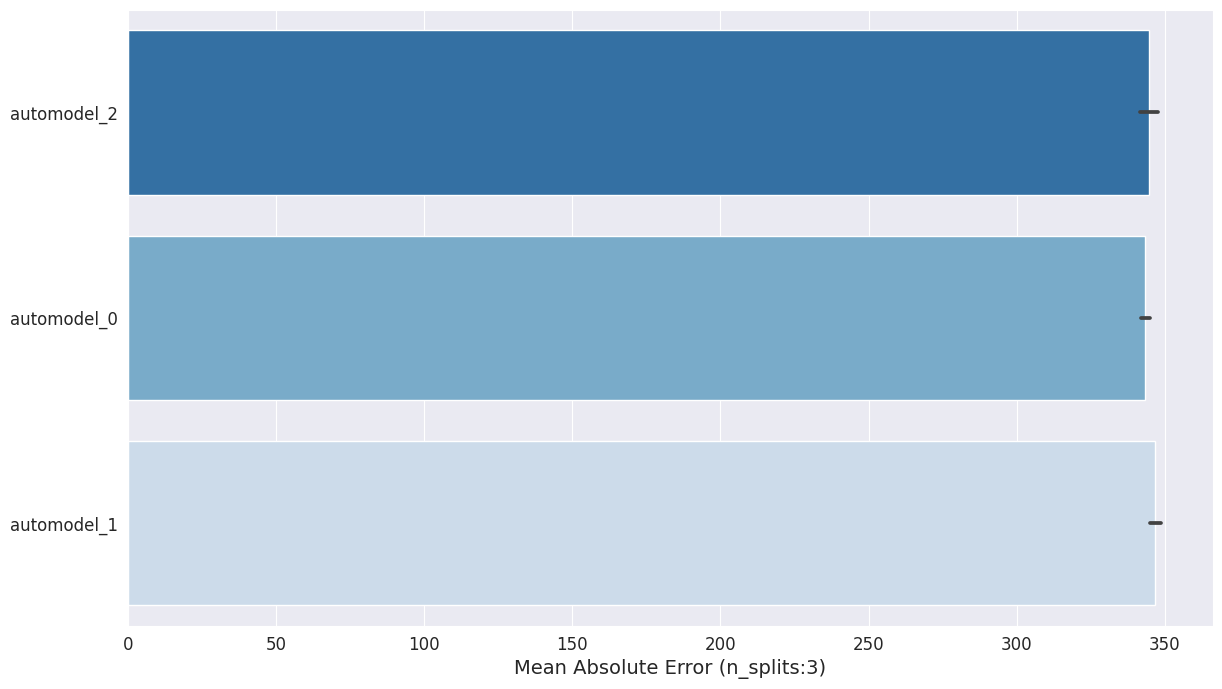

score_df:        variable     value
0  automodel_0  1.000000
1  automodel_0  1.000000
2  automodel_0  1.000000
6  automodel_2  0.964879
7  automodel_2  0.328910
5  automodel_1  0.043263
3  automodel_1  0.000000
4  automodel_1  0.000000
8  automodel_2  0.000000


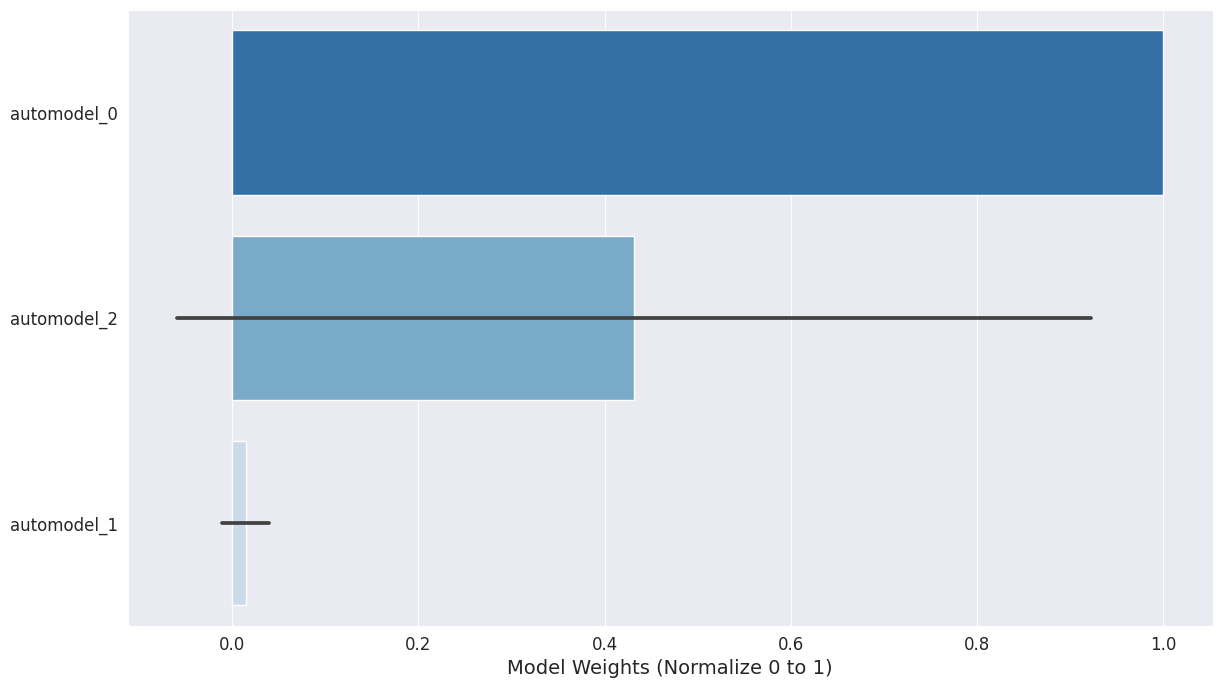

------------------------------
Ensemble MAE score 342.26202 ± 1.89788
------------------------------
--- Model Weights ---
automodel_0: 0.68495 ± 0.17532
----------
automodel_1: 0.14669 ± 0.10375
----------
automodel_2: 0.34042 ± 0.10318
----------
------------------------------


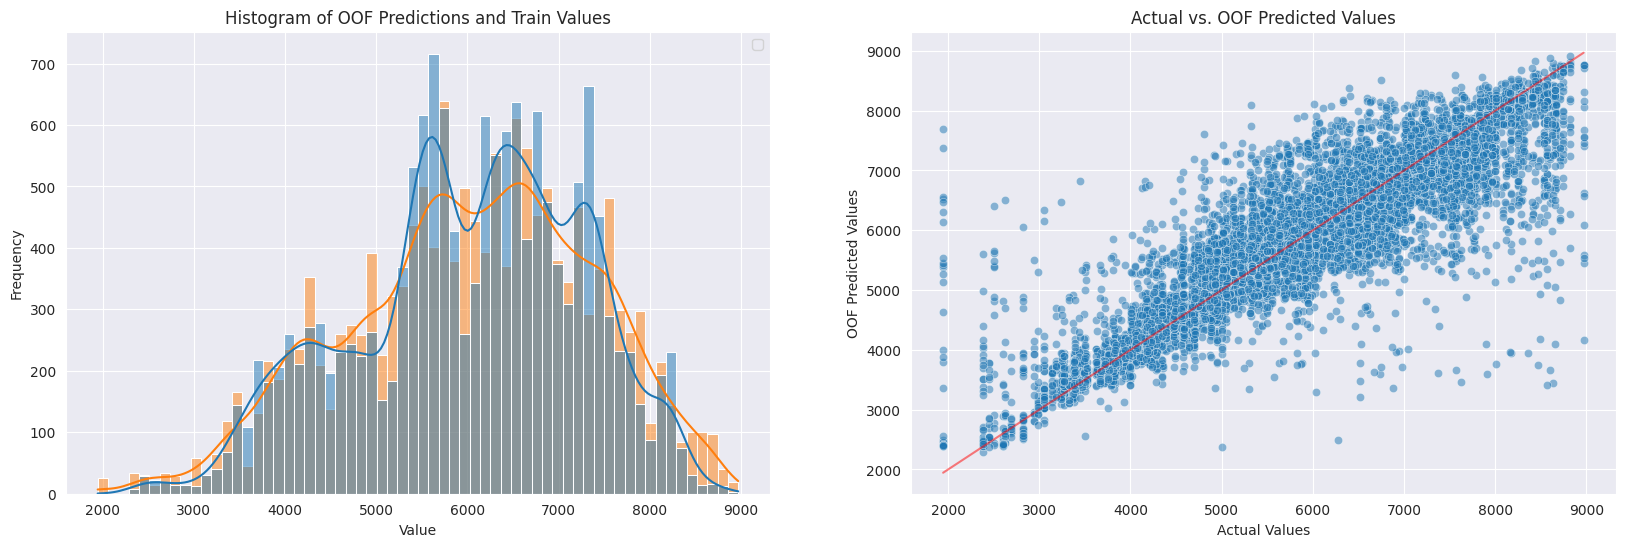

**************************************************
Post processing...
------------------------------


In [41]:


config = {
    'choice': 1,
    'random_state': 21,
    'aggr_type': 'mae',  # simple / mae_weighted / loss_weighted / optuna_mae

    'estimator_list': ['xgb', 'lgb'],
    'model_name': 'automl_model_1',

    'include_orig_data': False,

    'feature_version': None,  # None, v1, v2, v3

    'predict_log': False, # to train model to predict log(price); for price is a heavy tailed distribution

    'handle_outliers': False,
    'outlier_handling_method': 'winsorize',

    'scale_data': False,
    'scaler_type': 'robust',  # standard / robust / minma
    'enable_categorical': False,

    'fold_split_type': 'kfold',
    'num_folds': 3,
    'folds_to_train': [0,1,2],
    'automl_internal_num_folds': 5,  # Number of folds to find 'optimal' hyper-params config by automl
    'num_automl_repeats_per_fold': 3,  # Number of seeds tried - per fold.
    'validate_only_comp_data': True,

    'postprocess_approach': 'nearest_neighbour',

    'time_budget_per_fold_automl_minutes': 1, # in minutes - per fold, per seed - each call to fit_automl()

    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'verbose': -1,

    'device': 'cpu',
    'use_gpu_if_available': True,
    'predictor': 'gpu_predictor',
    'use_wandb': False, # Defaults to true if choice==3.
    'n_jobs': -1,
    'data_dir': '/content/data/',
    'drive_project_dir': '/content/drive/MyDrive/AutoML',
    'project_name': 'AutoML_demo',
}



if config['choice'] == 3: config['use_wandb'] = True

if config['use_wandb']:
  os.environ['WANDB_MODE'] = 'online'
  try:
    wandb.login(key='REDACTED')
  except:
    wandb.login()
else:
  os.environ['WANDB_MODE'] = 'offline'

set_seeds(config)

if config['choice'] == 1:
  train_k_folds()
elif config['choice'] == 2:
  test_model(config)
elif config['choice'] == 3:
  sweep_configs = {
      "method": "grid",
      "metric": {
          "name": "Fold average val MAE",
          "goal": "minimize",
      },
      "parameters": {
          "colsample_bytree": {
              "values": [0.6, 0.8, 1.0]
          },
          "subsample": {
              "values": [0.6, 0.8, 1.0]
          },
          "max_depth": {
              "values": [5, 8, 12]
          },
          'max_leaves': {
              'values': [32, 64, 128],
          },
          "reg_alpha": {
              "values": [0, 1.0, 3.0]
          },
          "reg_lambda": {
              "values": [0.0, 1.0, 3.0]
          },
          # "learning_rate": {
          #     "values": [0.01, 0.05, 0.1, 0.3, 0.5]
          # }
          # "random_state": {
          #     "values": [0.01, 0.05, 0.1, 0.3, 0.5]
          # },
          # "max_bin": {
          #     "values": [64, 128, 256, 512, 1024],
          # },
          # "min_data_in_leaf": {
          #     "values": [1, 8, 20, 32, 64],
          # },
          "min_child_weight": {
            "values": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
          },
        }
  }
  print("Running sweep>>>>>>>>>>>>>>>>>>>>>>>>")
  sweep_id = wandb.sweep(sweep=sweep_configs, project=config['project_name']+'_sweep')
  wandb.agent(sweep_id=sweep_id, function=train_k_folds, count=7)
else:
  raise ValueError(f"Incorrect value for 'choice'={config['choice']} in config")

